<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Running%20inference%20with%20a%20custom%20TFOD%20API%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook how to run inference with the model trained in [this notebook](https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Training_a_pets_detector_model_within_minutes_with_TFOD_API.ipynb). 

## Set up TFOD API

In [1]:
import tensorflow as tf 
print(tf.__version__)

2.2.0


In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
%cd models/research

# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.

# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

## Set up GCP utilities

In [5]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [6]:
#@title Configure GCP project
GCP_PROJECT_ID = "fast-ai-exploration" #@param {type:"string"} 
!gcloud config set project $GCP_PROJECT_ID

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [8]:
#@title GCS bucket name
YOUR_GCS_BUCKET = "pet_detector_tf2" #@param {type:"string"}
YOUR_GCS_BUCKET = 'gs://' + YOUR_GCS_BUCKET
print(f'GCS bucket to be used: {YOUR_GCS_BUCKET}')

GCS bucket to be used: gs://pet_detector_tf2


## Copy the model checkpoints locally

In [12]:
#@title Model directory name
MODEL_DIR = "pets_detector" #@param {type:"string"}
print(f'Model directory: {YOUR_GCS_BUCKET + "/" + MODEL_DIR}')
MODEL_DIR = YOUR_GCS_BUCKET + "/" + MODEL_DIR
!gsutil -m cp -r $MODEL_DIR .

Model directory: gs://pet_detector_tf2/pets_detector
Copying gs://pet_detector_tf2/pets_detector/checkpoint...
Copying gs://pet_detector_tf2/pets_detector/ckpt-2.index...
Copying gs://pet_detector_tf2/pets_detector/ckpt-1.index...
Copying gs://pet_detector_tf2/pets_detector/ckpt-1.data-00001-of-00002...
Copying gs://pet_detector_tf2/pets_detector/ckpt-2.data-00001-of-00002...
Copying gs://pet_detector_tf2/pets_detector/ckpt-2.data-00000-of-00002...
Copying gs://pet_detector_tf2/pets_detector/ckpt-1.data-00000-of-00002...
Copying gs://pet_detector_tf2/pets_detector/ckpt-3.data-00001-of-00002...
Copying gs://pet_detector_tf2/pets_detector/ckpt-3.data-00000-of-00002...
Copying gs://pet_detector_tf2/pets_detector/ckpt-3.index...
Copying gs://pet_detector_tf2/pets_detector/eval/events.out.tfevents.1594447686.cmle-training-2714458894516470398.508.1376.v2...
Copying gs://pet_detector_tf2/pets_detector/packages/644510e33e503dd7ace482cc2c4934e14a4a499583683ca60d2877f51b7bca9a/object_detection-0

## Model config file

In [16]:
!wget https://gist.githubusercontent.com/sayakpaul/70c414fbe581def12f4b500659372c4f/raw/4f6c52548749c2991af4357e0fe07466382274a1/pets_detector.config

--2020-07-13 05:21:34--  https://gist.githubusercontent.com/sayakpaul/70c414fbe581def12f4b500659372c4f/raw/4f6c52548749c2991af4357e0fe07466382274a1/pets_detector.config
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4463 (4.4K) [text/plain]
Saving to: ‘pets_detector.config’

pets_detector.confi 100%[===================>]   4.36K  --.-KB/s    in 0s      

2020-07-13 05:21:34 (27.0 MB/s) - ‘pets_detector.config’ saved [4463/4463]



From here, we are going to follow [this notebook](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb). 

## Utilities for running inference

In [22]:
import matplotlib
import matplotlib.pyplot as plt

import io
import os
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Load the model checkpoints as a standalone function

In [23]:
pipeline_config = '/content/models/research/pets_detector.config'
model_dir = '/content/models/research/pets_detector/'

In [25]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-3')).expect_partial() # Can vary 

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

## Prepare label map for converting class ids to labels

In [26]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

## Image processing utils

In [27]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Prepare an image and run inference

--2020-07-13 05:33:15--  https://www.gannett-cdn.com/-mm-/8b15e053fba5438a91d1bff3d4704868a0ce7579/c=68-0-731-373/local/-/media/2018/05/10/USATODAY/usatsports/MotleyFool-TMOT-816b1ceb-0ece06e3.jpg?width=660
Resolving www.gannett-cdn.com (www.gannett-cdn.com)... 151.101.2.62, 151.101.66.62, 151.101.130.62, ...
Connecting to www.gannett-cdn.com (www.gannett-cdn.com)|151.101.2.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23974 (23K) [image/jpeg]
Saving to: ‘image.png’

image.png           100%[===================>]  23.41K  --.-KB/s    in 0.01s   

2020-07-13 05:33:15 (1.86 MB/s) - ‘image.png’ saved [23974/23974]



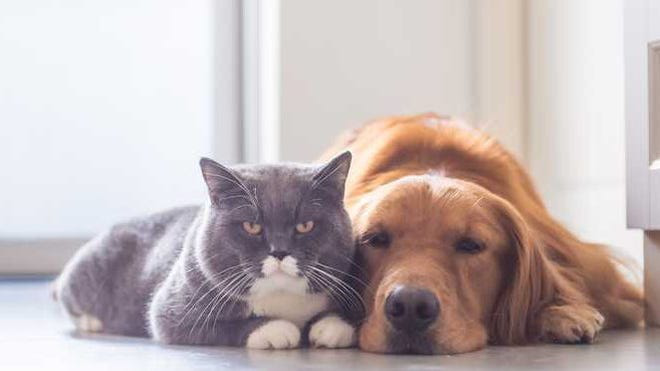

In [30]:
#@title Supply a path to download a relevant image
IMAGE_PATH = "https://www.gannett-cdn.com/-mm-/8b15e053fba5438a91d1bff3d4704868a0ce7579/c=68-0-731-373/local/-/media/2018/05/10/USATODAY/usatsports/MotleyFool-TMOT-816b1ceb-0ece06e3.jpg?width=660&height=372&fit=crop&format=pjpg&auto=webp" #@param {type:"string"}

!wget -O image.png $IMAGE_PATH
Image.open('image.png')

In [31]:
image_np = load_image_into_numpy_array('image.png')
image_np.shape

(371, 660, 3)

In [32]:
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0


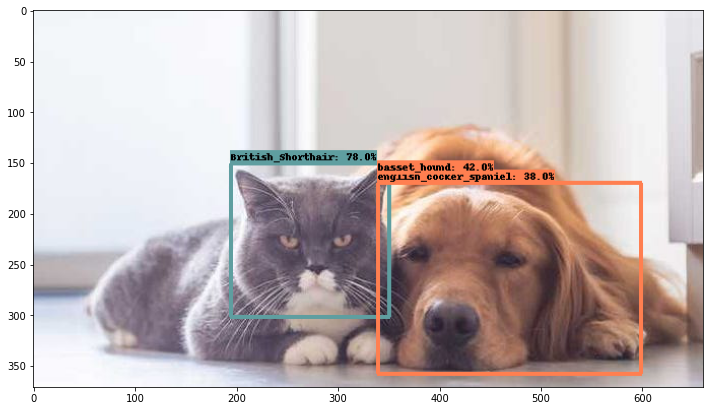

In [34]:
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=None,
      keypoint_scores=None,
      keypoint_edges=None)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()